In [ ]:
import torch
# torch.cuda.set_device(1)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig 
model_type = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_type, do_lower_case=True)
config = AutoConfig.from_pretrained(model_type, num_labels=2, output_attentions=False, output_hidden_states=False)
model = AutoModelForSequenceClassification.from_pretrained(model_type, config=config)


In [ ]:
model.load_state_dict(torch.load('/mnt/rao/home/zb/GAT_code/sst_model/bert-base-uncased-advk-30/9.pt'))
model.cuda()

In [ ]:
from utils import get_sst_data, get_imdb_data, get_imdb_unsup_data, get_agnews_data, set_seed, flat_accuracy, encode_fn

In [ ]:
train_texts, train_labels = get_sst_data('train')
all_train_ids = encode_fn(tokenizer, train_texts, dataset='sst')
labels = torch.tensor(train_labels)

In [ ]:
test_texts, test_labels = get_sst_data('dev')
all_test_ids = encode_fn(tokenizer, test_texts, dataset='sst')
test_labels = torch.tensor(test_labels)

In [ ]:
import csv 
test_texts, test_labels = [], []
with open('TextAttack/2022-11-18-15-09-log.csv', 'r', encoding='utf8') as f:
    f = csv.reader(f)
    f = list(f)[1:]
    for line in f:
        if line[8] == 'Successful' or line[8] == 'Failed':
            test_texts.append(str(line[1]))
            test_labels.append(int(float(line[6])))
print(len(test_labels))
print(len(test_texts))
all_test_ids = encode_fn(tokenizer, test_texts, sst=True)
test_labels = torch.tensor(test_labels)


In [ ]:
set_seed(2021)
device = torch.device('cuda:0')

In [ ]:
def build_inputs(batch):
    '''
    Sent all model inputs to the appropriate device (GPU on CPU)
    rreturn:
     The inputs are in a dictionary format
    '''
    input_keys = ['input_ids', 'attention_mask', 'token_type_ids', 'labels']
    batch = (batch[0].to(device), (batch[0]>0).to(device), None, batch[1].long().to(device))
    # batch = tuple(t.to(device) for t in batch)
    inputs = {key: value for key, value in zip(input_keys, batch)}
    return inputs


In [ ]:
advk10_flooding_loss_landscape = []
advk10_flooding_acc = []
advk10_loss_landscape = []
advk10_acc = []
advk30_flooding_loss_landscape = []
advk30_flooding_acc = []
advk30_loss_landscape = []
advk30_acc = []


In [ ]:
advk30_loss_landscape = []
advk30_acc = []

In [ ]:
len(advk10_loss_landscape)

In [ ]:
flooding_loss_landscape = []
flooding_acc = []

In [ ]:
torch.cuda.set_device(1)

In [ ]:
model.eval()
batch = (all_test_ids, test_labels)
inputs = build_inputs(batch)
outputs = model(**inputs)
loss, logits = outputs[:2]
logits = logits.detach().cpu().numpy()
label_ids = batch[1].to('cpu').numpy()
acc = flat_accuracy(logits, label_ids)
print(loss.item())
print(acc)

In [ ]:
import numpy as np
np.log(1.5508161783218384)

In [ ]:
from adversarial_train import FreeLB
def loss_acc_of_strength(path, epoch=9, testdata=True):
    loss_list, acc_list = [], []
    
    model_path = path+str(epoch)+'.pt'
    model.load_state_dict(torch.load(model_path))
    model.cuda()  
    model.eval()
    
    for k in range(50):
        tmp_acc = 0
        tmp_loss = 0
        # batch = (all_train_ids[0:128], labels[0:128])
        for ii in range(6):
            if testdata:
                batch = (all_test_ids[ii*128:(ii+1)*128], test_labels[ii*128:(ii+1)*128])
            else:
                batch = (all_train_ids[ii*128:(ii+1)*128], labels[ii*128:(ii+1)*128])
            inputs = build_inputs(batch)
            adv_trainer = FreeLB(adv_K=k+1,adv_lr=1e-2,adv_init_mag=2e-2,adv_max_norm=1,adv_norm_type='l2',base_model='bert',f_b=0,flooding=False)
            loss, logits = adv_trainer.attack(model, inputs, gradient_accumulation_steps=1)
            logits_de = logits.detach().cpu().numpy()
            label_ids = batch[1].to('cpu').numpy()
            acc = flat_accuracy(logits_de, label_ids)
            tmp_acc += acc / 6
            tmp_loss += loss.item() / 6
        
        loss_list.append(tmp_loss)
        acc_list.append(acc_list)

    return loss_list, acc_list 


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
advk_range = np.arange(100)
# plt.plot(advk_range, [0]*100, 'violet', linestyle='--')
# plt.plot(advk_range, np.log(advk30_flooding_loss_landscape), 'y', label='freelb++30_flooding_bert_loss',linewidth=3)
# plt.plot(advk_range, np.log(advk30_loss_landscape), 'r', label='freelb++30_bert_loss',linewidth=3)
# plt.plot(advk_range, np.log(advk10_flooding_loss_landscape), 'm', label='freelb++10_flooding_bert_loss',linewidth=3)
# plt.plot(advk_range, np.log(advk10_loss_landscape), 'b', label='freelb++10_bert_loss',linewidth=3)
plt.plot(advk_range, np.log(flooding_loss_landscape), 'y', label='flooding0.025_bert_loss', linewidth=3)
plt.legend()
plt.xlabel('PGD attack steps')
plt.ylabel('Log CE Loss')
plt.show()

In [ ]:
# plt.plot(advk_range, advk10_acc, 'b', label='freelb++10_bert_robust_acc',linewidth=3)
# plt.plot(advk_range, advk10_flooding_acc, 'm', label='freelb++10_flooding_bert_robust_acc',linewidth=3)
# plt.plot(advk_range, advk30_acc, 'r', label='freelb++30_bert_robust_acc',linewidth=3)
# plt.plot(advk_range, advk30_flooding_acc, 'y', label='freelb++30_flooding_bert_robust_acc',linewidth=3)
plt.plot(advk_range, flooding_acc, 'y', label='flooding0.025_bert_robust_acc',linewidth=3)
plt.legend()
plt.xlabel('PGD attack steps')
plt.ylabel('robust acc')
plt.show()


In [ ]:
from adversarial_train import FreeLB
from tqdm import tqdm 

In [ ]:
def loss_acc_of_epochs(path, k=10, testdata=True):
    loss_list, acc_list = [], []
    for i in tqdm(range(100)):
        # model_path = './sst_model/bert-base-uncased-advk-10/'+str(i)+'.pt'
        model_path = path + str(i) + '.pt' 
        # model_path = '/mnt/rao/home/zb/Flooding-X/saved_models_tavat/TAVAT_bert-base-uncased_glue_sst2_adv10_epochs100_test/epoch'+str(i)+'/pytorch_model.bin'
        model.load_state_dict(torch.load(model_path))
        model.cuda()
        model.eval()
        tmp_acc = 0
        tmp_loss = 0
        for ii in range(6):
            if testdata:
                batch = (all_test_ids[ii*128:(ii+1)*128], test_labels[ii*128:(ii+1)*128])
            else:
                batch = (all_train_ids[ii*128:(ii+1)*128], labels[ii*128:(ii+1)*128])
            # batch = (all_train_ids[0:128], labels[0:128])
            inputs = build_inputs(batch)
            adv_trainer = FreeLB(adv_K=k,adv_lr=1e-2,adv_init_mag=2e-2,adv_max_norm=1,adv_norm_type='l2',base_model='bert',f_b=0,flooding=False)
            loss, logits = adv_trainer.attack(model, inputs, gradient_accumulation_steps=1)

            logits_de = logits.detach().cpu().numpy()
            label_ids = batch[1].to('cpu').numpy()
            acc = flat_accuracy(logits_de, label_ids)
            tmp_acc += acc / 6
            tmp_loss += loss.item() / 6
        loss_list.append(tmp_loss)
        acc_list.append(tmp_acc)
        # print('loss:{}'.format(loss.item()))
        # print('acc:{}'.format(acc))
        # print('=============================================')
    return loss_list, acc_list



In [ ]:
advk_10_test_loss_list = loss_list
advk_10_test_acc_list = acc_list

In [ ]:
freelb10_test_loss_list, freelb10_test_acc_list = loss_acc_of_epochs(path='./sst_model/bert-base-uncased-advk-10/', k=10, testdata=True)

In [ ]:
np.save('./fig/advk10/tavat10_test_acc_list.npy',tavat10_test_acc_list)

In [ ]:
advk_30_flooding_test_loss_list, advk_30_flooding_test_acc_list  = loss_acc_of_epochs('./sst_model/bert-base-uncased-advk-30-flooding0.1/', \
                                                                                                                            k=30, testdata=True)

In [ ]:
advk_30_test_loss_list, advk_30_test_acc_list  = loss_acc_of_epochs('./sst_model/bert-base-uncased-advk-30/', k=30, testdata=True)

In [ ]:
advk_30_test_advk10_loss_list, advk_30_test_advk10_acc_list  = loss_acc_of_epochs('./sst_model/bert-base-uncased-advk-30/', k=10, testdata=True)

In [ ]:
advk_30_flooding_train_loss_list, advk_30_flooding_train_acc_list  = loss_acc_of_epochs('./sst_model/bert-base-uncased-advk-30-flooding0.1/', \
                                                                                                                            k=30, testdata=False)
advk_30_train_loss_list, advk_30_train_acc_list  = loss_acc_of_epochs('./sst_model/bert-base-uncased-advk-30/', k=30, testdata=False)

In [ ]:
advk_10_flooding_train_loss_list, advk_10_flooding_train_acc_list = \
    loss_acc_of_epochs('./sst_model/bert-base-uncased-advk-10-flooding0.2/', testdata=False)

In [ ]:
advk_10_train_loss_list, advk_10_train_acc_list = \
    loss_acc_of_epochs('./sst_model/bert-base-uncased-advk-10/', k=10, testdata=False)

In [ ]:
advk_10_test_advk3_loss_list, advk_10_test_advk3_acc_list = \
    loss_acc_of_epochs('./sst_model/bert-base-uncased-advk-10/', k=3, testdata=True)

In [21]:
import numpy as np

# bert_test_loss_list = np.load('./fig/advk10/bert_test_loss_list.npy')
# bert_test_acc_list = np.load('./fig/advk10/bert_test_acc_list.npy')

tavat10_train_loss_list = np.load('./fig/advk10/tavat10_train_loss_list.npy')
tavat10_train_acc_list = np.load('./fig/advk10/tavat10_train_acc_list.npy')

infobert10_train_loss_list = np.load('./fig/advk10/infobert10_train_loss_list.npy')
infobert10_train_acc_list = np.load('./fig/advk10/infobert10_train_acc_list.npy')

freelb10_train_loss_list = np.load('./fig/advk10/freelb10_train_loss_list.npy')
freelb10_train_acc_list = np.load('./fig/advk10/freelb10_train_acc_list.npy')

freelb10_flooding_test_loss_list = np.load('./fig/advk10/freelb10_flooding_test_loss_list.npy')
freelb10_flooding_test_acc_list = np.load('./fig/advk10/freelb10_flooding_test_acc_list.npy')

freelb10_test_loss_list = np.load('./fig/advk10/freelb10_test_loss_list.npy')
freelb10_test_acc_list = np.load('./fig/advk10/freelb10_test_acc_list.npy')

tavat10_test_loss_list = np.load('./fig/advk10/tavat10_test_loss_list.npy')
tavat10_test_acc_list = np.load('./fig/advk10/tavat10_test_acc_list.npy')

tavat10_flooding_test_loss_list = np.load('./fig/advk10/tavat10_flooding_test_loss_list.npy')
tavat10_flooding_test_acc_list = np.load('./fig/advk10/tavat10_flooding_test_acc_list.npy')

infobert10_test_loss_list = np.load('./fig/advk10/infobert10_test_loss_list.npy')
infobert10_test_acc_list = np.load('./fig/advk10/infobert10_test_acc_list.npy')


infobert10_flooding_test_loss_list = np.load('./fig/advk10/infobert10_flooding_test_loss_list.npy')
infobert10_flooding_test_acc_list = np.load('./fig/advk10/infobert10_flooding_test_acc_list.npy')

infobert_training_loss_list = np.load('./fig/advk10/infobert_training_loss_list.npy')
tavat_training_loss_list = np.load('./fig/advk10/tavat_training_loss_list.npy')


In [25]:
import numpy as np 
# deberta agnews
freelb10_flooding_test_loss_list = np.load('./fig/advk10/deberta/agnews/freelb_10_flooding_test_loss_list.npy')
freelb10_flooding_test_acc_list = np.load('./fig/advk10/deberta/agnews/freelb_10_flooding_test_acc_list.npy')

freelb10_test_loss_list = np.load('./fig/advk10/deberta/agnews/freelb_10_test_loss_list.npy')
freelb10_test_acc_list = np.load('./fig/advk10/deberta/agnews/freelb_10_test_acc_list.npy')

tavat10_test_loss_list = np.load('./fig/advk10/deberta/agnews/tavat_10_test_loss_list.npy')
tavat10_test_acc_list = np.load('./fig/advk10/deberta/agnews/tavat_10_test_acc_list.npy')

tavat10_flooding_test_loss_list = np.load('./fig/advk10/deberta/agnews/tavat_10_flooding_test_loss_list.npy')
tavat10_flooding_test_acc_list = np.load('./fig/advk10/deberta/agnews/tavat_10_flooding_test_acc_list.npy')

infobert10_test_loss_list = np.load('./fig/advk10/deberta/agnews/infobert_10_test_loss_list.npy')
infobert10_test_acc_list = np.load('./fig/advk10/deberta/agnews/infobert_10_test_acc_list.npy')


infobert10_flooding_test_loss_list = np.load('./fig/advk10/deberta/agnews/infobert_10_flooding_test_loss_list.npy')
infobert10_flooding_test_acc_list = np.load('./fig/advk10/deberta/agnews/infobert_10_flooding_test_acc_list.npy')

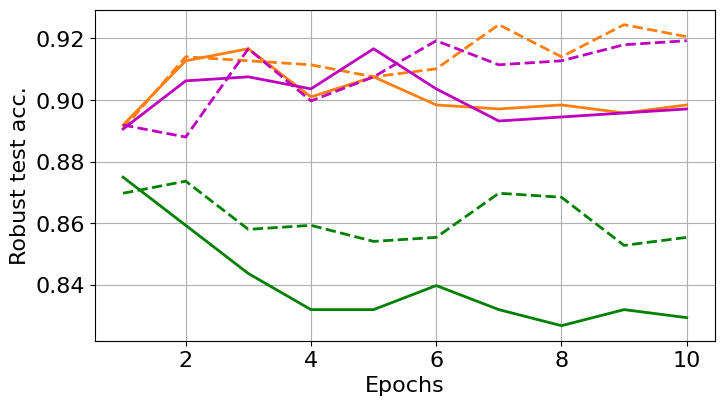

In [29]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
plt.rcParams['axes.facecolor']='white'

advk_range = np.arange(10)+1
# advk_range2 = np.arange(10)
# plt.plot(advk_range, advk_30_train_loss_list, 'b', label='advk30 robust training loss',linewidth=3)
# plt.plot(advk_range, advk_30_flooding_train_loss_list, 'r', label='advk30 flooding robust training loss',linewidth=3)
# advk_30_test_advk10_loss_list
fig = plt.figure(figsize=(8, 4.3))
# ax = fig.add_subplot(111)
# ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
plt.grid(True)

# plt.plot(advk_range, bert_test_loss_list, '#00BEBE', label='BERT',linewidth=3)
plt.plot(advk_range, tavat10_test_acc_list, '#008000', label='TAVAT-10 test',linewidth=2)
# plt.plot(advk_range, tavat_training_loss_list, '#008000', label='training',linewidth=3,linestyle='--')
plt.plot(advk_range, tavat10_flooding_test_acc_list, '#008000', label='+flooding',linewidth=2,linestyle='--')
plt.plot(advk_range, freelb10_test_acc_list, '#FF7E0E', label='FreeLB-10 test',linewidth=2)
# plt.plot(advk_range, freelb10_train_loss_list, '#FF7E0E', label='training',linewidth=3,linestyle='--')
plt.plot(advk_range, freelb10_flooding_test_acc_list, '#FF7E0E', label='+flooding',linewidth=2,linestyle='--')
plt.plot(advk_range, infobert10_test_acc_list, '#BE00BE', label='InfoBERT-10 test',linewidth=2)
# plt.plot(advk_range, infobert_training_loss_list, '#BE00BE', label='training',linewidth=3,linestyle='--')
plt.plot(advk_range, infobert10_flooding_test_acc_list, '#BE00BE', label='+flooding',linewidth=2,linestyle='--')
# plt.ylim(0.7,1.01)

# plt.plot(advk_range, tavat10_train_loss_list, '#008000', label='TAVAT-10 re-attack',linewidth=3)
# plt.plot(advk_range, freelb10_train_loss_list, '#FF7E0E', label='FreeLB-10 re-attack',linewidth=3)
# plt.plot(advk_range, infobert10_train_loss_list, '#BE00BE', label='InfoBERT-10 re-attack',linewidth=3)

# plt.plot(advk_range, tavat10_train_acc_list, '#008000', label='TAVAT-10 re-attack',linewidth=3)
# plt.plot(advk_range, freelb10_train_acc_list, '#FF7E0E', label='FreeLB-10 re-attack',linewidth=3)
# plt.plot(advk_range, infobert10_train_acc_list, '#BE00BE', label='InfoBERT-10 re-attack',linewidth=3)
# plt.legend(fontsize=14, ncol=3, bbox_to_anchor=(1.02,1.25))
# bbox_to_anchor=(1.02,1.25)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Robust test acc.',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.ylim(0.55,0.9)
# plt.savefig('./fig/advk10/Robust training acc of re-attack on the training set.pdf',bbox_inches='tight')
# plt.savefig('./fig/advk10/Robust test loss of ori vs +flooding.pdf',bbox_inches='tight')
plt.savefig('./fig/advk10/deberta/agnews/Robust test acc. of ori vs +flooding.pdf',bbox_inches='tight')
plt.show()


In [14]:
infobert10_cali_test_loss_list = np.load('./fig/advk10/infobert10_cali_test_loss_list.npy', )
infobert10_cali_test_acc_list = np.load('./fig/advk10/infobert10_cali_test_acc_list.npy',)

freelb10_cali_test_loss_list = np.load('./fig/advk10/freelb10_cali_test_loss_list.npy', )
freelb10_cali_test_acc_list = np.load('./fig/advk10/freelb10_cali_test_acc_list.npy',)

tavat10_cali_test_loss_list = np.load('./fig/advk10/tavat10_cali_test_loss_list.npy', )
tavat10_cali_test_acc_list = np.load('./fig/advk10/tavat10_cali_test_acc_list.npy',)

infobert10_cali_train_loss_list = np.load('./fig/advk10/infobert10_cali_train_loss_list.npy', )
infobert10_cali_train_acc_list = np.load('./fig/advk10/infobert10_cali_train_acc_list.npy',)

freelb10_cali_train_loss_list = np.load('./fig/advk10/freelb10_cali_train_loss_list.npy', )
freelb10_cali_train_acc_list = np.load('./fig/advk10/freelb10_cali_train_acc_list.npy',)

tavat10_cali_train_loss_list = np.load('./fig/advk10/tavat10_cali_train_loss_list.npy', )
tavat10_cali_train_acc_list = np.load('./fig/advk10/tavat10_cali_train_acc_list.npy',)


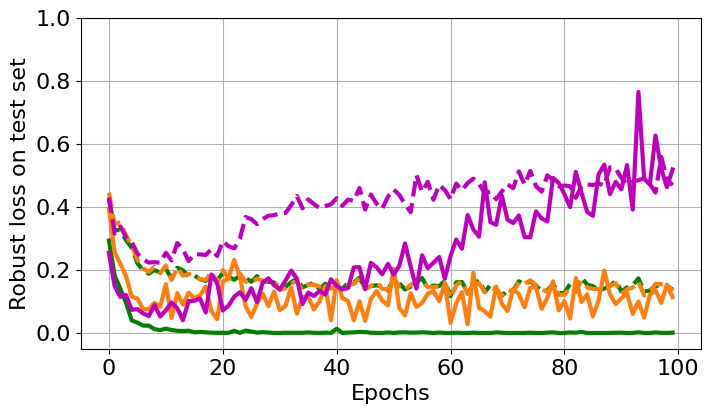

In [22]:
import numpy as np 
import matplotlib.pyplot as plt 
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(8, 4.3))
plt.grid(True)
advk_range = np.arange(100)
advk_range2 = np.arange(10)
# plt.plot(advk_range, bert_test_acc_list, '#00BEBE', label='BERT',linewidth=3)
# plt.plot(advk_range, advk_10_test_acc_list, 'b', label='advk10 robust test acc',linewidth=3)
# plt.plot(advk_range, advk_30_flooding_train_acc_list, 'r', label='advk30 flooding robust train acc',linewidth=3)
# plt.plot(advk_range, advk_30_train_acc_list, 'b', label='advk30 robust train acc',linewidth=3)
# plt.plot(advk_range, tavat10_test_acc_list, 'b', label='tavat10 robust test acc',linewidth=3)
plt.plot(advk_range, tavat10_train_loss_list, '#008000', label='TAVAT-10',linewidth=3)
plt.plot(advk_range, tavat10_cali_train_loss_list, '#008000', label='TAVAT-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, tavat10_train_acc_list, '#008000', label='TAVAT-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, tavat10_flooding_test_acc_list, '#008000', label='TAVAT-10+flooding',linewidth=2,linestyle='--')
plt.plot(advk_range, freelb10_train_loss_list, '#FF7E0E', label='FreeLB-10',linewidth=3)
plt.plot(advk_range, freelb10_cali_train_loss_list, '#FF7E0E', label='FreeLB-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, freelb10_train_acc_list, '#FF7E0E', label='FreeLB-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, freelb10_flooding_test_acc_list, '#FF7E0E', label='FreeLB-10+flooding',linewidth=2,linestyle='--')
plt.plot(advk_range, infobert10_train_loss_list, '#BE00BE', label='InfoBERT-10',linewidth=3)
plt.plot(advk_range, infobert10_cali_train_loss_list, '#BE00BE', label='InfoBERT-10 cali',linewidth=3,linestyle='--')
# plt.plot(advk_range, infobert10_train_acc_list, '#BE00BE', label='InfoBERT-10',linewidth=3,linestyle='--')
# plt.plot(advk_range2, infobert10_flooding_test_acc_list, '#BE00BE', label='infobert10 flooding robust test acc',linewidth=2,linestyle='--')
plt.ylim(-0.05,1)
# plt.legend(fontsize=13)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs',fontsize=16,)
plt.ylabel('Robust loss on test set',fontsize=16)
# plt.savefig('./fig/advk10/robust test loss of ori vs cali.pdf',bbox_inches='tight')
plt.show()

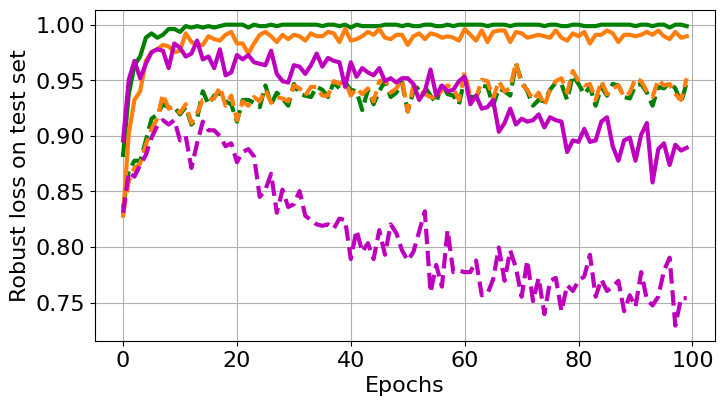

In [16]:
import numpy as np 
import matplotlib.pyplot as plt 
plt.rcParams['axes.facecolor']='white'
plt.figure(figsize=(8, 4.3))
plt.grid(True)
advk_range = np.arange(100)
advk_range2 = np.arange(10)
# plt.plot(advk_range, bert_test_acc_list, '#00BEBE', label='BERT',linewidth=3)
# plt.plot(advk_range, advk_10_test_acc_list, 'b', label='advk10 robust test acc',linewidth=3)
# plt.plot(advk_range, advk_30_flooding_train_acc_list, 'r', label='advk30 flooding robust train acc',linewidth=3)
# plt.plot(advk_range, advk_30_train_acc_list, 'b', label='advk30 robust train acc',linewidth=3)
# plt.plot(advk_range, tavat10_test_acc_list, 'b', label='tavat10 robust test acc',linewidth=3)
plt.plot(advk_range, tavat10_train_acc_list, '#008000', label='TAVAT-10',linewidth=3)
plt.plot(advk_range, tavat10_cali_train_acc_list, '#008000', label='TAVAT-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, tavat10_train_acc_list, '#008000', label='TAVAT-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, tavat10_flooding_test_acc_list, '#008000', label='TAVAT-10+flooding',linewidth=2,linestyle='--')
plt.plot(advk_range, freelb10_train_acc_list, '#FF7E0E', label='FreeLB-10',linewidth=3)
plt.plot(advk_range, freelb10_cali_train_acc_list, '#FF7E0E', label='FreeLB-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, freelb10_train_acc_list, '#FF7E0E', label='FreeLB-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, freelb10_flooding_test_acc_list, '#FF7E0E', label='FreeLB-10+flooding',linewidth=2,linestyle='--')
plt.plot(advk_range, infobert10_train_acc_list, '#BE00BE', label='InfoBERT-10',linewidth=3)
plt.plot(advk_range, infobert10_cali_train_acc_list, '#BE00BE', label='InfoBERT-10 cali',linewidth=3,linestyle='--')
# plt.plot(advk_range, infobert10_train_acc_list, '#BE00BE', label='InfoBERT-10',linewidth=3,linestyle='--')
# plt.plot(advk_range2, infobert10_flooding_test_acc_list, '#BE00BE', label='infobert10 flooding robust test acc',linewidth=2,linestyle='--')
# plt.ylim(0.6,1.0)
# plt.legend(fontsize=13)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs',fontsize=16,)
plt.ylabel('Robust loss on test set',fontsize=16)
# plt.savefig('./fig/advk10/robust test loss of ori vs cali.pdf',bbox_inches='tight')
plt.show()

In [33]:
import numpy as np 
freelb10_epoch0_test_loss_list = np.load('./fig/advk10/freelb10_epoch0_test_loss_list.npy')
freelb10_epoch0_test_acc_list = np.load('./fig/advk10/freelb10_epoch0_test_acc_list.npy')

freelb10_epoch9_test_loss_list = np.load('./fig/advk10/freelb10_epoch9_test_loss_list.npy')
freelb10_epoch9_test_acc_list = np.load('./fig/advk10/freelb10_epoch9_test_acc_list.npy')

freelb10_epoch19_test_loss_list = np.load('./fig/advk10/freelb10_epoch19_test_loss_list.npy')
freelb10_epoch19_test_acc_list = np.load('./fig/advk10/freelb10_epoch19_test_acc_list.npy')

freelb10_epoch29_test_loss_list = np.load('./fig/advk10/freelb10_epoch29_test_loss_list.npy')
freelb10_epoch29_test_acc_list = np.load('./fig/advk10/freelb10_epoch29_test_acc_list.npy')

freelb10_epoch49_test_loss_list = np.load('./fig/advk10/freelb10_epoch49_test_loss_list.npy')
freelb10_epoch49_test_acc_list = np.load('./fig/advk10/freelb10_epoch49_test_acc_list.npy')

freelb10_epoch99_test_loss_list = np.load('./fig/advk10/freelb10_epoch99_test_loss_list.npy')
freelb10_epoch99_test_acc_list = np.load('./fig/advk10/freelb10_epoch99_test_acc_list.npy')

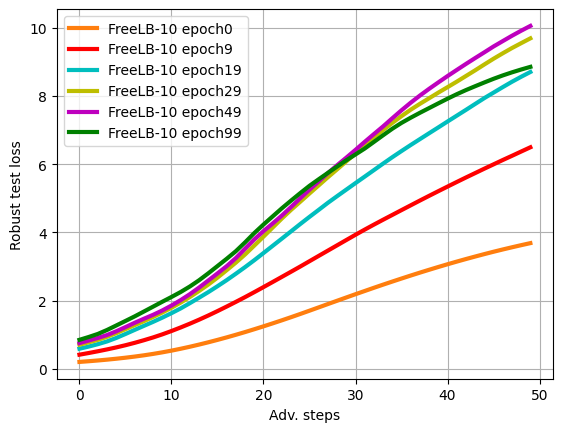

In [151]:

import matplotlib.pyplot as plt 
# plt.rcParams['axes.facecolor']='ghostwhite'
plt.grid(True)
advk_range = np.arange(50)

plt.plot(advk_range, freelb10_epoch0_test_loss_list, '#FF7E0E', label='FreeLB-10 epoch0',linewidth=3)
plt.plot(advk_range, freelb10_epoch9_test_loss_list, '#FF0000', label='FreeLB-10 epoch9',linewidth=3)
plt.plot(advk_range, freelb10_epoch19_test_loss_list, '#00BEBE', label='FreeLB-10 epoch19',linewidth=3)
plt.plot(advk_range, freelb10_epoch29_test_loss_list, '#BEBE00', label='FreeLB-10 epoch29',linewidth=3)
plt.plot(advk_range, freelb10_epoch49_test_loss_list, '#BE00BE', label='FreeLB-10 epoch49',linewidth=3)
plt.plot(advk_range, freelb10_epoch99_test_loss_list, '#008000', label='FreeLB-10 epoch99',linewidth=3)

plt.legend()
plt.xlabel('Adv. steps')
plt.ylabel('Robust test loss')
plt.show()

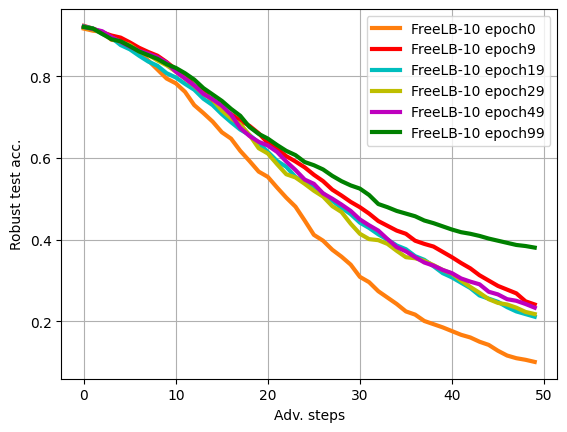

In [152]:
import matplotlib.pyplot as plt 
# plt.rcParams['axes.facecolor']='ghostwhite'
plt.grid(True)
advk_range = np.arange(50)

plt.plot(advk_range, freelb10_epoch0_test_acc_list, '#FF7E0E', label='FreeLB-10 epoch0',linewidth=3)
plt.plot(advk_range, freelb10_epoch9_test_acc_list, '#FF0000', label='FreeLB-10 epoch9',linewidth=3)
plt.plot(advk_range, freelb10_epoch19_test_acc_list, '#00BEBE', label='FreeLB-10 epoch19',linewidth=3)
plt.plot(advk_range, freelb10_epoch29_test_acc_list, '#BEBE00', label='FreeLB-10 epoch29',linewidth=3)
plt.plot(advk_range, freelb10_epoch49_test_acc_list, '#BE00BE', label='FreeLB-10 epoch49',linewidth=3)
plt.plot(advk_range, freelb10_epoch99_test_acc_list, '#008000', label='FreeLB-10 epoch99',linewidth=3)

plt.legend()
plt.xlabel('Adv. steps')
plt.ylabel('Robust test acc.')
plt.show()

In [8]:
import numpy as np 
freelb10_epoch9_train_loss_list = np.load('./fig/advk10/freelb10_epoch9_train_loss_list.npy')
freelb10_epoch9_train_acc_list = np.load('./fig/advk10/freelb10_epoch9_train_acc_list.npy')

tavat10_epoch9_train_loss_list = np.load('./fig/advk10/tavat10_epoch9_train_loss_list.npy')
tavat10_epoch9_train_acc_list = np.load('./fig/advk10/tavat10_epoch9_train_acc_list.npy')

infobert10_epoch9_train_loss_list = np.load('./fig/advk10/infobert10_epoch9_train_loss_list.npy')
infobert10_epoch9_train_acc_list = np.load('./fig/advk10/infobert10_epoch9_train_acc_list.npy')

freelb10_epoch49_train_loss_list = np.load('./fig/advk10/freelb10_epoch49_train_loss_list.npy')
freelb10_epoch49_train_acc_list = np.load('./fig/advk10/freelb10_epoch49_train_acc_list.npy')

tavat10_epoch49_train_loss_list = np.load('./fig/advk10/tavat10_epoch49_train_loss_list.npy')
tavat10_epoch49_train_acc_list = np.load('./fig/advk10/tavat10_epoch49_train_acc_list.npy')

infobert10_epoch49_train_loss_list = np.load('./fig/advk10/infobert10_epoch49_train_loss_list.npy')
infobert10_epoch49_train_acc_list = np.load('./fig/advk10/infobert10_epoch49_train_acc_list.npy')

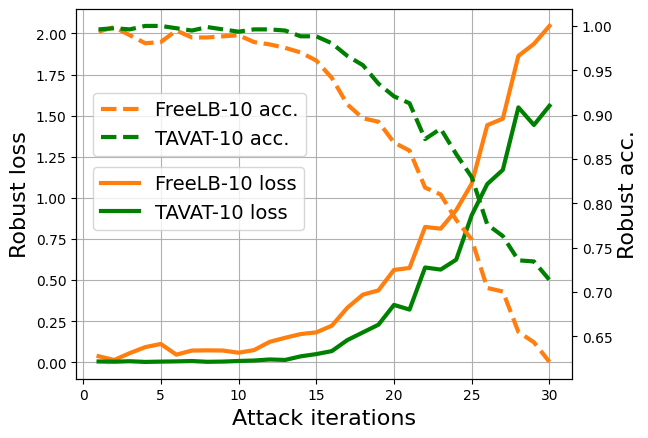

In [68]:
import matplotlib.pyplot as plt 
# plt.rcParams['axes.facecolor']='ghostwhite'
# plt.grid(True)
advk_range = np.arange(30)+1
fig = plt.figure()
ax = fig.add_subplot()
ax.grid(True)
ax.plot(advk_range, freelb10_epoch9_train_loss_list, '#FF7E0E', label='FreeLB-10 loss',linewidth=3)
ax.plot(advk_range, tavat10_epoch9_train_loss_list, '#008000', label='TAVAT-10 loss',linewidth=3)
# plt.plot(advk_range, infobert10_epoch9_train_loss_list, '#BE00BE', label='InfoBERT-10',linewidth=3)

# plt.plot(advk_range, freelb10_epoch49_train_loss_list, '#FF7E0E', label='FreeLB-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, tavat10_epoch49_train_loss_list, '#008000', label='TAVAT-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, infobert10_epoch49_train_loss_list, '#BE00BE', label='InfoBERT-10',linewidth=3,linestyle='--')


# plt.plot(advk_range, freelb10_epoch29_test_acc_list, '#BEBE00', label='FreeLB-10 epoch29',linewidth=3)
# plt.plot(advk_range, freelb10_epoch49_test_acc_list, '#BE00BE', label='FreeLB-10 epoch49',linewidth=3)
# plt.plot(advk_range, freelb10_epoch99_test_acc_list, '#008000', label='FreeLB-10 epoch99',linewidth=3)

ax.legend(fontsize=14,bbox_to_anchor=(0.48,0.6))
ax.set_xlabel('Attack iterations',fontsize=16,)
ax.set_ylabel('Robust loss',fontsize=16,)

ax2=ax.twinx()
ax2.plot(advk_range, freelb10_epoch9_train_acc_list, '#FF7E0E', label='FreeLB-10 acc.',linewidth=3,linestyle='--')
ax2.plot(advk_range, tavat10_epoch9_train_acc_list, '#008000', label='TAVAT-10 acc.',linewidth=3,linestyle='--')
ax2.legend(fontsize=14,bbox_to_anchor=(0.484,0.8))
# ax2.set_xlabel('Adv. steps')
ax2.set_ylabel('Robust acc.',fontsize=16,)
plt.savefig('./fig/advk10/robust test loss and acc. of adv steps.pdf',bbox_inches='tight')
plt.show()

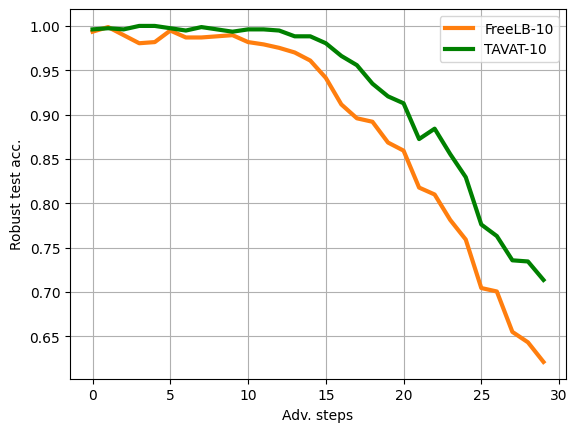

In [17]:
import matplotlib.pyplot as plt 
# plt.rcParams['axes.facecolor']='ghostwhite'
plt.grid(True)
advk_range = np.arange(30)

plt.plot(advk_range, freelb10_epoch9_train_acc_list, '#FF7E0E', label='FreeLB-10',linewidth=3)
plt.plot(advk_range, tavat10_epoch9_train_acc_list, '#008000', label='TAVAT-10',linewidth=3)
# plt.plot(advk_range, infobert10_epoch9_train_acc_list, '#BE00BE', label='InfoBERT-10',linewidth=3)

# plt.plot(advk_range, freelb10_epoch49_train_acc_list, '#FF7E0E', label='FreeLB-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, tavat10_epoch49_train_acc_list, '#008000', label='TAVAT-10',linewidth=3,linestyle='--')
# plt.plot(advk_range, infobert10_epoch49_train_acc_list, '#BE00BE', label='InfoBERT-10',linewidth=3,linestyle='--')

# plt.plot(advk_range, freelb10_epoch29_test_acc_list, '#BEBE00', label='FreeLB-10 epoch29',linewidth=3)
# plt.plot(advk_range, freelb10_epoch49_test_acc_list, '#BE00BE', label='FreeLB-10 epoch49',linewidth=3)
# plt.plot(advk_range, freelb10_epoch99_test_acc_list, '#008000', label='FreeLB-10 epoch99',linewidth=3)

plt.legend()
plt.xlabel('Adv. steps')
plt.ylabel('Robust test acc.')
plt.show()

In [1]:
import numpy as np
# weight decay
freelb10_test_loss_list_0_0_1 = np.load('./fig/advk10/freelb10_test_loss_list.npy')
freelb10_test_loss_list_0_1 = np.load('./fig/advk10/weight_decay/freelb10_test_loss_list_0.1.npy')
freelb10_test_loss_list_0_5 = np.load('./fig/advk10/weight_decay/freelb10_test_loss_list_0.5.npy')
freelb10_test_loss_list_1 = np.load('./fig/advk10/weight_decay/freelb10_test_loss_list_1.npy')
freelb10_test_loss_list_5 = np.load('./fig/advk10/weight_decay/freelb10_test_loss_list_5.npy')
freelb10_test_loss_list_10 = np.load('./fig/advk10/weight_decay/freelb10_test_loss_list_10.npy')
freelb10_test_loss_list_100 = np.load('./fig/advk10/weight_decay/freelb10_test_loss_list_100.npy')

freelb10_test_acc_list_0_0_1 = np.load('./fig/advk10/freelb10_test_acc_list.npy')
freelb10_test_acc_list_0_1 = np.load('./fig/advk10/weight_decay/freelb10_test_acc_list_0.1.npy')
freelb10_test_acc_list_0_5 = np.load('./fig/advk10/weight_decay/freelb10_test_acc_list_0.5.npy')
freelb10_test_acc_list_1 = np.load('./fig/advk10/weight_decay/freelb10_test_acc_list_1.npy')
freelb10_test_acc_list_5 = np.load('./fig/advk10/weight_decay/freelb10_test_acc_list_5.npy')
freelb10_test_acc_list_10 = np.load('./fig/advk10/weight_decay/freelb10_test_acc_list_10.npy')
freelb10_test_acc_list_100 = np.load('./fig/advk10/weight_decay/freelb10_test_acc_list_100.npy')

In [1]:
import numpy as np 
# flooding
freelb_10_flooding_0_test_loss_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0_test_loss_list.npy')
freelb_10_flooding_0_test_acc_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0_test_acc_list.npy')

freelb_10_flooding_00125_test_loss_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.0125_test_loss_list.npy')
freelb_10_flooding_00125_test_acc_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.0125_test_acc_list.npy')

freelb_10_flooding_0025_test_loss_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.025_test_loss_list.npy')
freelb_10_flooding_0025_test_acc_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.025_test_acc_list.npy')

freelb_10_flooding_005_test_loss_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.05_test_loss_list.npy')
freelb_10_flooding_005_test_acc_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.05_test_acc_list.npy')

freelb_10_flooding_01_test_loss_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.1_test_loss_list.npy')
freelb_10_flooding_01_test_acc_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.1_test_acc_list.npy')

freelb_10_flooding_02_test_loss_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.2_test_loss_list.npy')
freelb_10_flooding_02_test_acc_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.2_test_acc_list.npy')

freelb_10_flooding_035_test_loss_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.35_test_loss_list.npy')
freelb_10_flooding_035_test_acc_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.35_test_acc_list.npy')

freelb_10_flooding_05_test_loss_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.5_test_loss_list.npy')
freelb_10_flooding_05_test_acc_list = np.load('./fig/advk10/flooding/freelb_10_flooding_0.5_test_acc_list.npy')

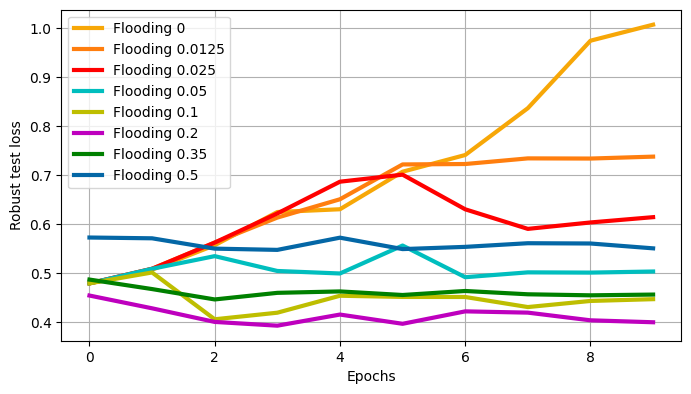

In [5]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(8, 4.3))
plt.grid(True)
advk_range = np.arange(10)
plt.plot(advk_range, freelb_10_flooding_0_test_loss_list, '#F7A707', label='Flooding 0',linewidth=3)
plt.plot(advk_range, freelb_10_flooding_00125_test_loss_list, '#FF7E0E', label='Flooding 0.0125',linewidth=3)
plt.plot(advk_range, freelb_10_flooding_0025_test_loss_list, '#FF0000', label='Flooding 0.025',linewidth=3)
plt.plot(advk_range, freelb_10_flooding_005_test_loss_list, '#00BEBE', label='Flooding 0.05',linewidth=3)
plt.plot(advk_range, freelb_10_flooding_01_test_loss_list, '#BEBE00', label='Flooding 0.1',linewidth=3)
plt.plot(advk_range, freelb_10_flooding_02_test_loss_list, '#BE00BE', label='Flooding 0.2',linewidth=3)
plt.plot(advk_range, freelb_10_flooding_035_test_loss_list, '#008000', label='Flooding 0.35',linewidth=3)
plt.plot(advk_range, freelb_10_flooding_05_test_loss_list, '#0467A6', label='Flooding 0.5',linewidth=3)

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Robust test loss')
plt.savefig('./fig/advk10/flooding/flooding robust test loss.pdf',bbox_inches='tight')
plt.show()

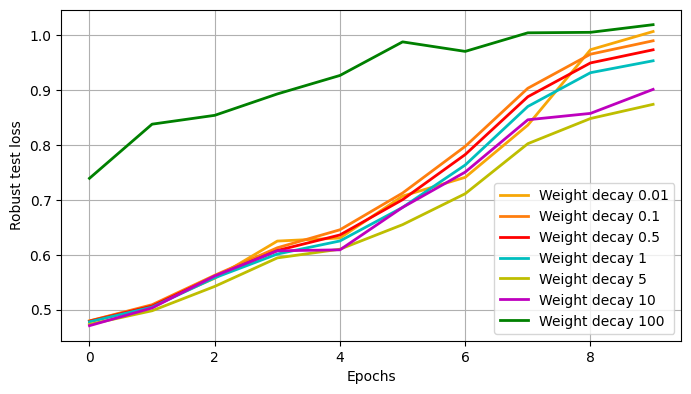

In [17]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(8, 4.3))
plt.grid(True)
advk_range = np.arange(10)

plt.plot(advk_range, freelb10_test_loss_list_0_0_1[:10], '#F7A707', label='Weight decay 0.01',linewidth=2)
plt.plot(advk_range, freelb10_test_loss_list_0_1, '#FF7E0E', label='Weight decay 0.1',linewidth=2)
plt.plot(advk_range, freelb10_test_loss_list_0_5, '#FF0000', label='Weight decay 0.5',linewidth=2)
plt.plot(advk_range, freelb10_test_loss_list_1, '#00BEBE', label='Weight decay 1',linewidth=2)
plt.plot(advk_range, freelb10_test_loss_list_5, '#BEBE00', label='Weight decay 5',linewidth=2)
plt.plot(advk_range, freelb10_test_loss_list_10, '#BE00BE', label='Weight decay 10',linewidth=2)
plt.plot(advk_range, freelb10_test_loss_list_100, '#008000', label='Weight decay 100',linewidth=2)

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Robust test loss')
plt.savefig('./fig/advk10/weight_decay/weight decay robust test loss.pdf',bbox_inches='tight')
plt.show()

In [1]:
import numpy as np
# dropout
freelb10_test_loss_list_0_1 = np.load('./fig/advk10/freelb10_test_loss_list.npy')
freelb10_test_loss_list_0_2 = np.load('./fig/advk10/dropout/freelb10_test_loss_list_0.2.npy')
freelb10_test_loss_list_0_3 = np.load('./fig/advk10/dropout/freelb10_test_loss_list_0.3.npy')
freelb10_test_loss_list_0_4 = np.load('./fig/advk10/dropout/freelb10_test_loss_list_0.4.npy')
freelb10_test_loss_list_0_5 = np.load('./fig/advk10/dropout/freelb10_test_loss_list_0.5.npy')
freelb10_test_loss_list_0_6 = np.load('./fig/advk10/dropout/freelb10_test_loss_list_0.6.npy')
freelb10_test_loss_list_0_7 = np.load('./fig/advk10/dropout/freelb10_test_loss_list_0.7.npy')
freelb10_test_loss_list_0_8 = np.load('./fig/advk10/dropout/freelb10_test_loss_list_0.8.npy')
freelb10_test_loss_list_0_9 = np.load('./fig/advk10/dropout/freelb10_test_loss_list_0.9.npy')

freelb10_test_acc_list_0_1 = np.load('./fig/advk10/freelb10_test_acc_list.npy')
freelb10_test_acc_list_0_2 = np.load('./fig/advk10/dropout/freelb10_test_acc_list_0.2.npy')
freelb10_test_acc_list_0_3 = np.load('./fig/advk10/dropout/freelb10_test_acc_list_0.3.npy')
freelb10_test_acc_list_0_4 = np.load('./fig/advk10/dropout/freelb10_test_acc_list_0.4.npy')
freelb10_test_acc_list_0_5 = np.load('./fig/advk10/dropout/freelb10_test_acc_list_0.5.npy')
freelb10_test_acc_list_0_6 = np.load('./fig/advk10/dropout/freelb10_test_acc_list_0.6.npy')
freelb10_test_acc_list_0_7 = np.load('./fig/advk10/dropout/freelb10_test_acc_list_0.7.npy')
freelb10_test_acc_list_0_8 = np.load('./fig/advk10/dropout/freelb10_test_acc_list_0.8.npy')
freelb10_test_acc_list_0_9 = np.load('./fig/advk10/dropout/freelb10_test_acc_list_0.9.npy')


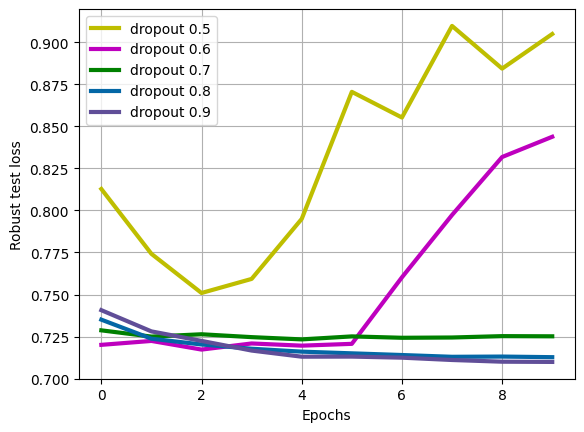

In [15]:
import matplotlib.pyplot as plt 

plt.grid(True)
advk_range = np.arange(10)

# plt.plot(advk_range, freelb10_test_loss_list_0_1[:10], '#F7A707', label='dropout 0.1',linewidth=3)
# plt.plot(advk_range, freelb10_test_loss_list_0_2, '#FF7E0E', label='dropout 0.2',linewidth=3)
# plt.plot(advk_range, freelb10_test_loss_list_0_3, '#FF0000', label='dropout 0.3',linewidth=3)
# plt.plot(advk_range, freelb10_test_loss_list_0_4, '#00BEBE', label='dropout 0.4',linewidth=3)
plt.plot(advk_range, freelb10_test_loss_list_0_5, '#BEBE00', label='dropout 0.5',linewidth=3)
plt.plot(advk_range, freelb10_test_loss_list_0_6, '#BE00BE', label='dropout 0.6',linewidth=3)
plt.plot(advk_range, freelb10_test_loss_list_0_7, '#008000', label='dropout 0.7',linewidth=3)
plt.plot(advk_range, freelb10_test_loss_list_0_8, '#0467A6', label='dropout 0.8',linewidth=3)
plt.plot(advk_range, freelb10_test_loss_list_0_9, '#604E98', label='dropout 0.9',linewidth=3)

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Robust test loss')
plt.savefig('./fig/advk10/dropout/dropout robust test loss [0.5-0.9].pdf',bbox_inches='tight')
plt.show()

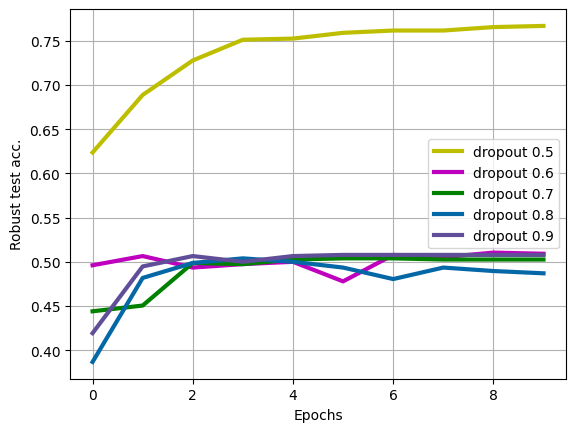

In [14]:
import matplotlib.pyplot as plt 

plt.grid(True)
advk_range = np.arange(10)

# plt.plot(advk_range, freelb10_test_acc_list_0_1[:10], '#F7A707', label='dropout 0.1',linewidth=3)
# plt.plot(advk_range, freelb10_test_acc_list_0_2, '#FF7E0E', label='dropout 0.2',linewidth=3)
# plt.plot(advk_range, freelb10_test_acc_list_0_3, '#FF0000', label='dropout 0.3',linewidth=3)
# plt.plot(advk_range, freelb10_test_acc_list_0_4, '#00BEBE', label='dropout 0.4',linewidth=3)
plt.plot(advk_range, freelb10_test_acc_list_0_5, '#BEBE00', label='dropout 0.5',linewidth=3)
plt.plot(advk_range, freelb10_test_acc_list_0_6, '#BE00BE', label='dropout 0.6',linewidth=3)
plt.plot(advk_range, freelb10_test_acc_list_0_7, '#008000', label='dropout 0.7',linewidth=3)
plt.plot(advk_range, freelb10_test_acc_list_0_8, '#0467A6', label='dropout 0.8',linewidth=3)
plt.plot(advk_range, freelb10_test_acc_list_0_9, '#604E98', label='dropout 0.9',linewidth=3)

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Robust test acc.')
plt.savefig('./fig/advk10/dropout/dropout robust test acc [0.5-0.9].pdf',bbox_inches='tight')
plt.show()

In [13]:
import numpy as np
# bert sst2 done
# deberta agnews done
# bert agnews 
# deberta sst2 done
freelb_test_loss = np.load('./fig/advk10/bert_agnews/freelb_10_test_loss_list.npy')
freelb_test_acc = np.load('./fig/advk10/bert_agnews/freelb_10_test_acc_list.npy')
freelb_train_loss = np.load('./fig/advk10/bert_agnews/freelb_10_train_loss_list.npy')
freelb_train_acc = np.load('./fig/advk10/bert_agnews/freelb_10_train_acc_list.npy')

tavat_test_loss = np.load('./fig/advk10/bert_agnews/tavat_10_test_loss_list.npy')
tavat_test_acc = np.load('./fig/advk10/bert_agnews/tavat_10_test_acc_list.npy')
tavat_train_loss = np.load('./fig/advk10/bert_agnews/tavat_10_train_loss_list.npy')
tavat_train_acc = np.load('./fig/advk10/bert_agnews/tavat_10_train_acc_list.npy')

infobert_test_loss = np.load('./fig/advk10/bert_agnews/infobert_10_test_loss_list.npy')
infobert_test_acc = np.load('./fig/advk10/bert_agnews/infobert_10_test_acc_list.npy')
infobert_train_loss = np.load('./fig/advk10/bert_agnews/infobert_10_train_loss_list.npy')
infobert_train_acc = np.load('./fig/advk10/bert_agnews/infobert_10_train_acc_list.npy')

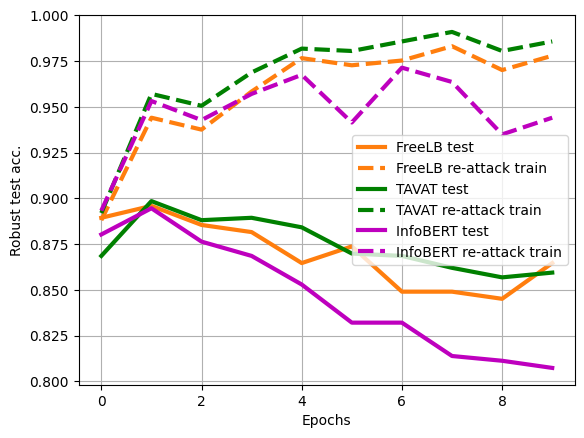

In [15]:
import matplotlib.pyplot as plt 

plt.grid(True)
advk_range = np.arange(10)

# plt.plot(advk_range, freelb_test_loss, '#FF7E0E', label='FreeLB test',linewidth=3)
# plt.plot(advk_range, freelb_train_loss, '#FF7E0E', label='FreeLB re-attack train',linewidth=3,linestyle='--')

# plt.plot(advk_range, tavat_test_loss, '#008000', label='TAVAT test',linewidth=3)
# plt.plot(advk_range, tavat_train_loss, '#008000', label='TAVAT re-attack train',linewidth=3,linestyle='--')

# plt.plot(advk_range, infobert_test_loss, '#BE00BE', label='InfoBERT test',linewidth=3)
# plt.plot(advk_range, infobert_train_loss, '#BE00BE', label='InfoBERT re-attack train',linewidth=3,linestyle='--')

plt.plot(advk_range, freelb_test_acc, '#FF7E0E', label='FreeLB test',linewidth=3)
plt.plot(advk_range, freelb_train_acc, '#FF7E0E', label='FreeLB re-attack train',linewidth=3,linestyle='--')

plt.plot(advk_range, tavat_test_acc, '#008000', label='TAVAT test',linewidth=3)
plt.plot(advk_range, tavat_train_acc, '#008000', label='TAVAT re-attack train',linewidth=3,linestyle='--')

plt.plot(advk_range, infobert_test_acc, '#BE00BE', label='InfoBERT test',linewidth=3)
plt.plot(advk_range, infobert_train_acc, '#BE00BE', label='InfoBERT re-attack train',linewidth=3,linestyle='--')


plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Robust test acc.')
plt.savefig('./fig/advk10/bert_agnews/robust acc. test vs. train.pdf',bbox_inches='tight')
plt.show()